In [1]:
import stan

import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [2]:
import warnings
warnings.filterwarnings('once')

In [3]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az # For visualization and loo
import seaborn as sns 

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In this homework, you're going to go through an exercise in going from a problem description, to writing down a statistical model, to fitting it both using raw Python and in Stan

**Model**: We have two independent variables (covariates), $x1$ and $x2$, and two unknown latent parameters $\alpha$ and $\beta$. The independent data $y$ is generated as follows. First, a coin is flipped and if it is heads, then $y = 0$. Otherwise, $y$ is drawn according to a Poisson random variable. This is typically called a "zero-inflated Poisson" model. 

The coin flip is heads with probability $logit^{-1}(\alpha x_1)$. The Poisson random variable has rate $e^{\beta x_2}$. 

Our prior is that $\alpha, \beta$ are both drawn from a uniform random variable between -1 and 1. The covariates are both drawn from a Normal distribution with mean 0 and variance 1. 

# Conceptual: Describe a research setting that conceivably corresponds to this data generating process 

# Write the statistical model down in math.
In other words, what are the distributions from which $x_1, x_2, \alpha, \beta, y$ are sampled?

Either using LaTeX within markdown, or inserting an image with math into the markdown. 

# Generate data from the true model, given fixed parameters $\alpha, \beta$

In [8]:
from scipy import stats
from scipy.stats import bernoulli, norm, poisson

def inv_logit(v):
    return 1/(1+np.exp(-v))

# TODO finish this function
# the output should be a dataframe with columns x1, x2, y
def generate_data(theta, N):
    alpha, beta = theta #as in lecture, theta = (alpha, beta)
    pass  

In [9]:
def plot_generated_data(df):
    sns.histplot(df.y)
    plt.yscale('log')
    plt.show()
    
    cuts = pd.DataFrame({str(feature) + 'Bin' : pd.qcut(df[feature], 5) for feature in ['x1', 'x2']})
    dfplot = pd.concat([df, cuts], axis=1)[['y', 'x1Bin', 'x2Bin']].groupby(['x1Bin', 'x2Bin']).mean().reset_index()
    dfpivot = dfplot.pivot(index='x1Bin', columns='x2Bin', values='y')
    plt.clf()
    sns.heatmap(dfpivot) 
    plt.title('Means of y vs Features x1 and x2')
    plt.tight_layout()
    plt.show()

The below will plot the data once you have filled out the above function

In [10]:
alpha, beta = (1, 1)
df = generate_data((alpha, beta), 1000)
plot_generated_data(df)

AttributeError: 'NoneType' object has no attribute 'y'

In [11]:
alpha, beta = (.5, -1)
df = generate_data((alpha, beta), 1000)
plot_generated_data(df)

AttributeError: 'NoneType' object has no attribute 'y'

# Calculate posterior using your own code

As we did in Lecture 2 and Lecture 4

In [12]:
# Prior for alpha, beta from the statistical model

#TODO finish this function for the pdf of theta. Hint: what is the area of the rectangle from -1 to 1 in both dimensions?
def p_theta(theta):
    pass

In [13]:
from scipy.stats import norm

# TODO finish this function for P({y} | theta, {x1}, {x2})
# Bonus: do this in log space to avoid underflow
def p_data_given_theta(theta, data, do_log = False):
    alpha, beta = theta
    ys = data['y']
    
    #TODO finish this function for P(y | theta, x1, x2)
    # Hint: there are 2 cases, y_i = 0 and y_i > 0
    # Hint: you'll use the inv_logit function defined above
    # Hint: you'll use the poisson distribution from scipy.stats, and the pmf method of the poisson distribution
    def single_y_likelihood(y, x1, x2):
        pass
    
    vals = [single_y_likelihood(y, x1, x2) for y, x1, x2 in zip(ys, data['x1'], data['x2'])]
    df['vals'] = vals
    
    # TODO finish below
    if not do_log:
        pass
    else:
        pass

# TODO finish this function for P(y | x1, x2)
# bonus: do this in log space to avoid underflow
def p_data(data, possible_theta_values, do_log = False):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    if not do_log:
        pass
    else:
        pass

Grid sampling

In [14]:
# TODO finish this function to sample possible_theta_values, p_theta_given_data using grid sampling
# bonus: do this in log space to avoid underflow
def grid_sampling(data, gridnum = 1000, do_log = False):
    possible_alpha_values = np.linspace(-1, 1, gridnum)
    possible_beta_values = np.linspace(-1, 1, gridnum)
    possible_theta_values = [(alpha, beta) for alpha in possible_alpha_values for beta in possible_beta_values]

    #TODO finish 
    p_theta_given_data = None

    return possible_theta_values, p_theta_given_data

In [15]:
true_alpha, true_beta = (.25, .5)
df = generate_data((true_alpha, true_beta), 100)

Below will plot posterior for alpha, beta using grid sampling

1.9054923818801246e-36


/tmp/ipykernel_25486/1084922637.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(dfplot.pivot('alpha', 'beta', 'p_theta_given_data'))


<AxesSubplot: xlabel='beta', ylabel='alpha'>

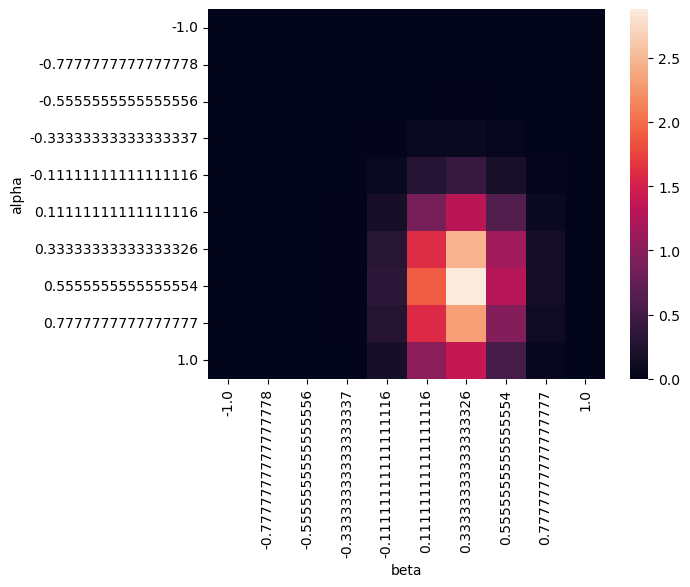

In [193]:
possible_theta_values, p_theta_given_data = grid_sampling(df, gridnum = 10)
dfplot = pd.DataFrame(possible_theta_values, columns=['alpha', 'beta'])
dfplot['p_theta_given_data'] = p_theta_given_data
from matplotlib.colors import LogNorm, Normalize
sns.heatmap(dfplot.pivot('alpha', 'beta', 'p_theta_given_data'))

Bonus: Below will plot log posterior for alpha, beta using grid sampling in log space.

-82.24832290442559


/tmp/ipykernel_25486/2599288042.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))


Text(0.5, 1.0, 'log_p_theta_given_data')

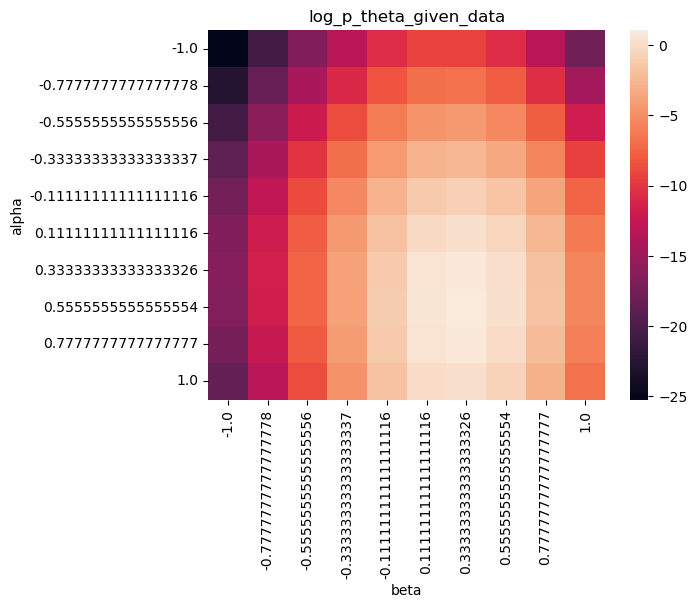

In [200]:
possible_theta_values, p_theta_given_data = grid_sampling(df, gridnum = 10, do_log=True)
dfplot = pd.DataFrame(possible_theta_values, columns=['alpha', 'beta'])
dfplot['log_p_theta_given_data'] = p_theta_given_data
sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))
plt.title('log_p_theta_given_data')

In log space, can do with larger datasets without underflow (though P(data) is still troublesome...)

-485.80193618784944


/tmp/ipykernel_25486/3852737199.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))


Text(0.5, 1.0, 'log_p_theta_given_data')

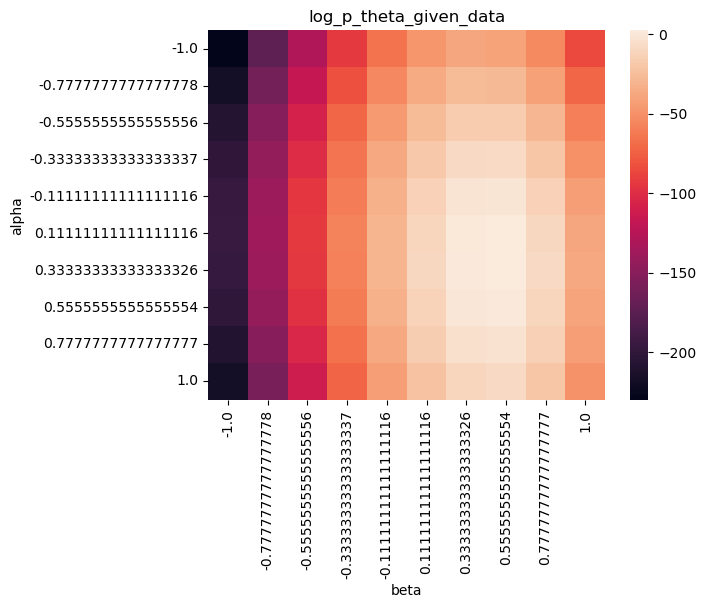

In [202]:
true_alpha, true_beta = (.25, .5)
df = generate_data((true_alpha, true_beta), 500)
possible_theta_values, p_theta_given_data = grid_sampling(df, gridnum = 10, do_log=True)
dfplot = pd.DataFrame(possible_theta_values, columns=['alpha', 'beta'])
dfplot['log_p_theta_given_data'] = p_theta_given_data
sns.heatmap(dfplot.pivot('alpha', 'beta', 'log_p_theta_given_data'))
plt.title('log_p_theta_given_data')

With more data points, we get much tighter posteriors (observe the color scale)

# Now, fit a Stan model for this dataset

In [259]:
true_alpha, true_beta = (.25, .5)
df = generate_data((true_alpha, true_beta), 1000)

## First, just fit a Poisson regression, ignoring the zero inflation

First, we'll fit a "mis-specified" model -- suppose we just fit a Poisson regression, i.e.:

\begin{align*}
    y &\sim Poisson (e^{intercept + \alpha*x_1 + \beta*x_2})
\end{align*}
The following will be useful: https://mc-stan.org/docs/functions-reference/poisson-log-glm.html. You'll likely need to directly increment the `target` parameter. 

In [279]:
stan_data = {'N': df.shape[0], 'y': df.y.values, 'X': df[['x1', 'x2']].values}

TODO: write a Stan model and save it in poissonregression.stan

In [280]:
stan_folder = './'
stan_file = stan_folder + 'poissonregression.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Stan code to fit normal distribution with improper prior

data {
  int<lower=0> N;
  int<lower=0> y[N];
  matrix[N,2] X;
}
parameters {
  real intercept;
  vector[2] beta;

}
model {
  intercept ~ normal(0, 2);
  beta ~ uniform(-1, 1);
  target += poisson_log_glm_lpmf(y | X, intercept, beta);
}



In [281]:
compiled_model = stan.build(model_code, data=stan_data)

Building...

In file included from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 from /home/nkgarg/miniconda3/lib/python3.9/site-packages/httpstan/include


Building: 19.0s, done.Messages from stanc:
Warning in '/tmp/httpstan_lmndvq9s/model_vg37dw75.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_lmndvq9s/model_vg37dw75.stan', line 15, column 2: Parameter
    beta is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distr

In [282]:
fit = compiled_model.sample(num_chains=2, num_warmup = 100, num_samples= 500)

Sampling:   0%
Sampling:  50% (600/1200)
Sampling: 100% (1200/1200)
Sampling: 100% (1200/1200), done.
Messages received during sampling:
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 15
             adapt_window = 75
             term_buffer = 10
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial

We wrote some of the code for you to analyze the model fit

In [288]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)

In [289]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.654,0.047,-0.742,-0.569,0.002,0.001,695.0,595.0,1.00
beta[0],0.176,0.039,0.098,0.242,0.001,0.001,930.0,573.0,1.01
beta[1],0.455,0.039,0.380,0.527,0.001,0.001,1026.0,721.0,1.01


array([<AxesSubplot: title={'center': 'intercept'}>,
       <AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

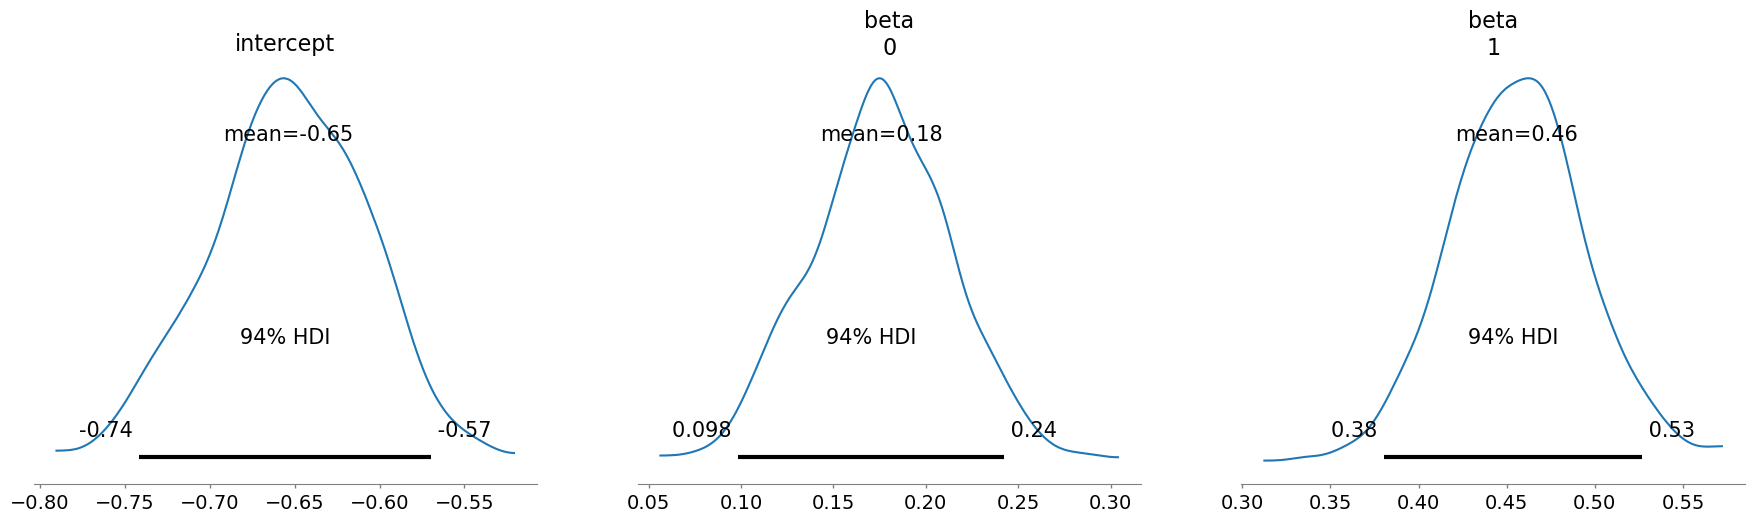

In [290]:
az.plot_posterior(idata)

array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'beta\n0'}>,
        <AxesSubplot: title={'center': 'beta\n0'}>],
       [<AxesSubplot: title={'center': 'beta\n1'}>,
        <AxesSubplot: title={'center': 'beta\n1'}>]], dtype=object)

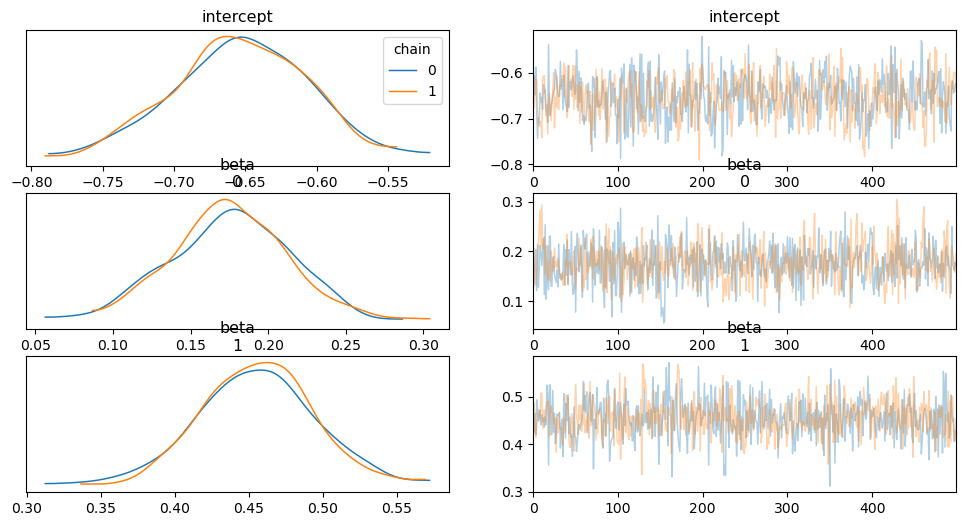

In [291]:
az.plot_trace(fit, compact=False, legend=True)

array([[<AxesSubplot: ylabel='beta\n0'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='intercept', ylabel='beta\n1'>,
        <AxesSubplot: xlabel='beta\n0'>]], dtype=object)

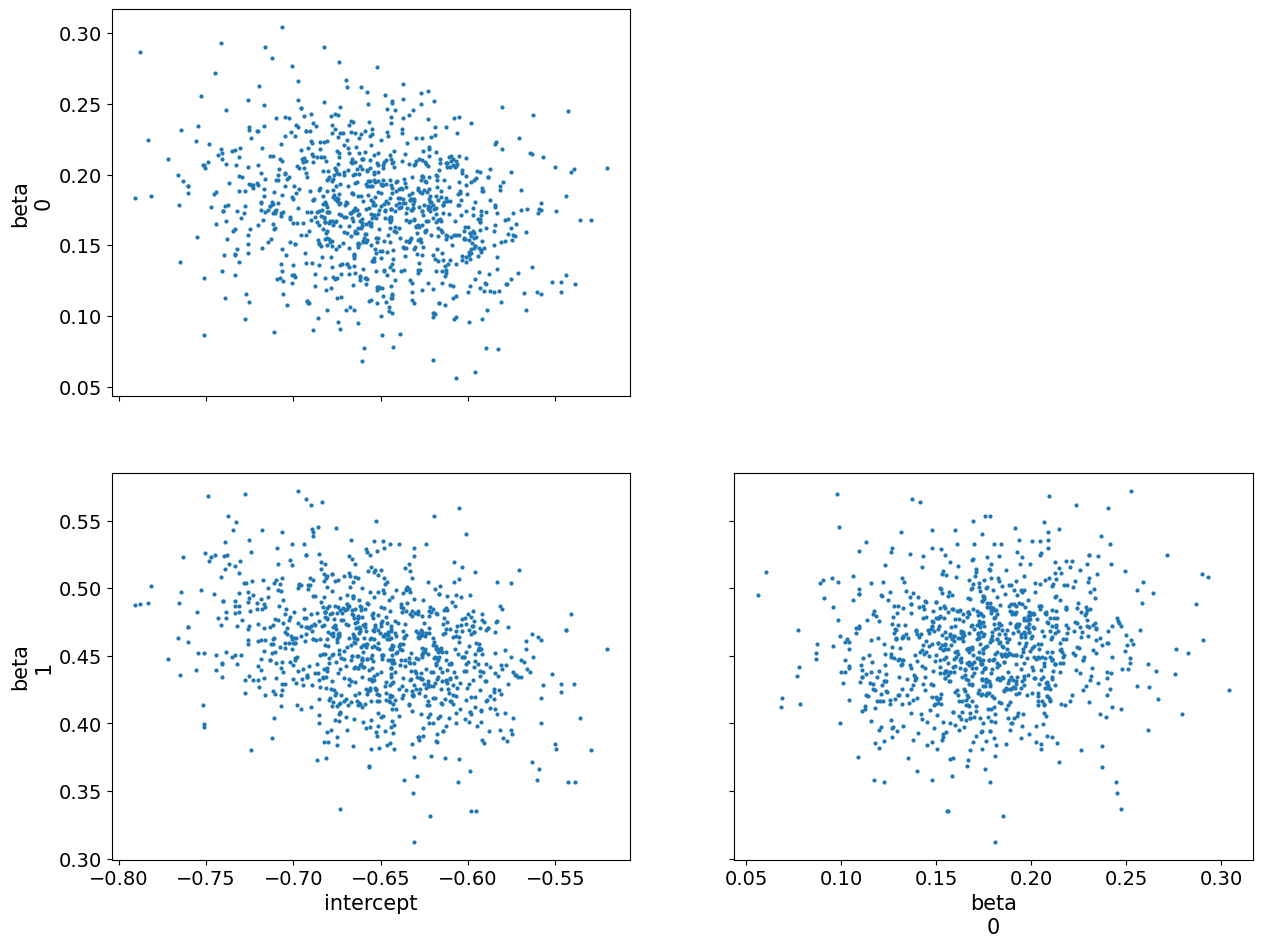

In [292]:
az.plot_pair(idata)

In [16]:
# TODO: In your poissonregression.stan file, use the generated quantities block to sample 
# from the posterior predictive distribution and plot the posterior predictive distribution here.
# Display it in the same plot as the true $y$ data, and comment on comparing the two.

In [17]:
# TODO bonus: use arviz to plot the posterior predictive distribution

## Now, fit a correct Stan model reflecting the true data generating process

Now, fit a zero inflated Poisson in stan.

Hint: you'll need to directly increment the `target` parameter.

Hint: you'll likely need the following functions: `log_sum_exp`, `bernoulli_logit_lpmf`, `poisson_log_glm_lpmf`

Hint: I had to play around a bit with the input parameter formatting (e.g., put x2 inside its own matrix)

In [18]:
stan_data = {}

In [19]:
stan_folder = './'
stan_file = stan_folder + 'zeroinflatedpoisson.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

// Stan code to fit normal distribution with improper prior

data {
  int<lower=0> N;
  int<lower=0> y[N];
  real x1[N];
  matrix[N,1] x2;
}
parameters {
  real alpha;
  vector[1] beta;

}
model {
  alpha ~ uniform(-1, 1);
  beta ~ uniform(-1, 1);
  for (n in 1:N){
      if (y[n] == 0) {
        target += log_sum_exp(bernoulli_logit_lpmf(0 | alpha*x1[n]),
                              bernoulli_logit_lpmf(1 | alpha*x1[n])
                                + poisson_log_glm_lpmf(y[n] | x2[n:n], 0, beta)
                                );
      } else {
        target += bernoulli_logit_lpmf(1 | alpha*x1[n])
                    + poisson_log_glm_lpmf(y[n] | x2[n:n], 0, beta); 

      }
    }
}

// generated quantities { NOT ready yet
//   //For posterior predictive check https://mc-stan.org/docs/2_28/stan-users-guide/simulating-from-the-posterior-predictive-distribution.html
//   //https://mc-stan.org/docs/2_19/functions-reference/poisson-distribution-log-parameterization.html
//     array

In [262]:
compiled_model = stan.build(model_code, data=stan_data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_46llw0yp/model_llscrj45.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_46llw0yp/model_llscrj45.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_46llw0yp/model_llscrj45.stan', line 16, column 2: Parameter
    beta is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
 

In [271]:
fit = compiled_model.sample(num_chains=2, num_warmup = 100, num_samples= 500)

Sampling:   0%
Sampling:   0% (1/1200)
Sampling:   0% (2/1200)
Sampling:  50% (601/1200)
Sampling: 100% (1200/1200)
Sampling: 100% (1200/1200), done.
Messages received during sampling:
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 0.000711 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.11 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 15
             adapt_window = 75
             term_buffer = 10
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity

In [283]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model)

In [284]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.654,0.047,-0.742,-0.569,0.002,0.001,695.0,595.0,1.00
beta[0],0.176,0.039,0.098,0.242,0.001,0.001,930.0,573.0,1.01
beta[1],0.455,0.039,0.380,0.527,0.001,0.001,1026.0,721.0,1.01


array([<AxesSubplot: title={'center': 'intercept'}>,
       <AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

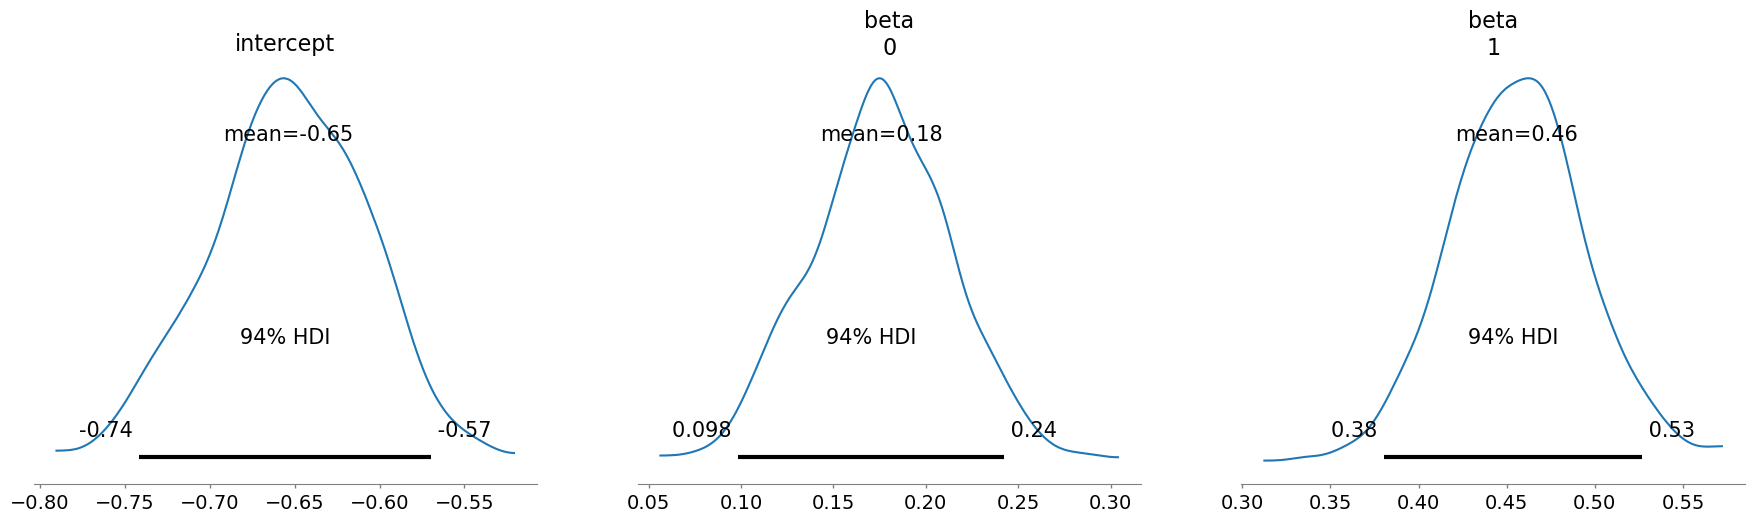

In [285]:
az.plot_posterior(idata)

array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'beta\n0'}>,
        <AxesSubplot: title={'center': 'beta\n0'}>],
       [<AxesSubplot: title={'center': 'beta\n1'}>,
        <AxesSubplot: title={'center': 'beta\n1'}>]], dtype=object)

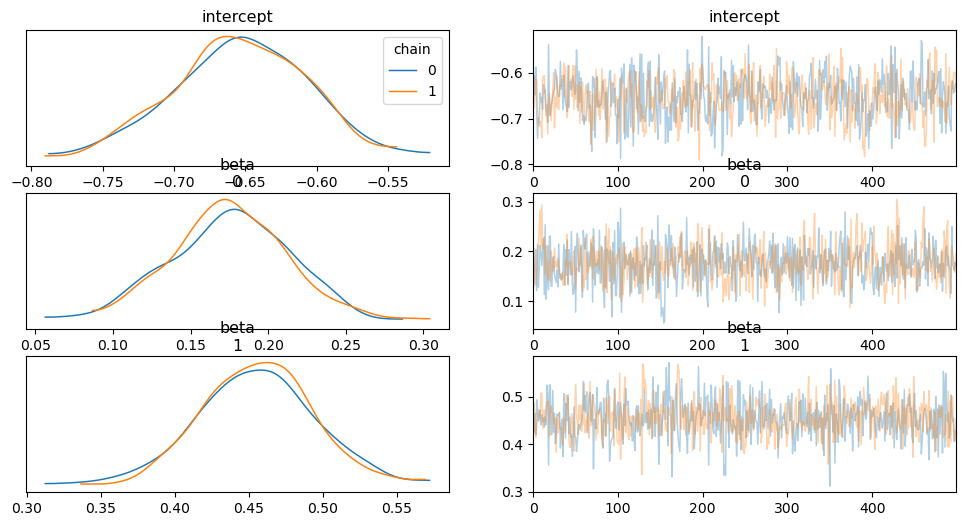

In [286]:
az.plot_trace(fit, compact=False, legend=True)

array([[<AxesSubplot: ylabel='beta\n0'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='intercept', ylabel='beta\n1'>,
        <AxesSubplot: xlabel='beta\n0'>]], dtype=object)

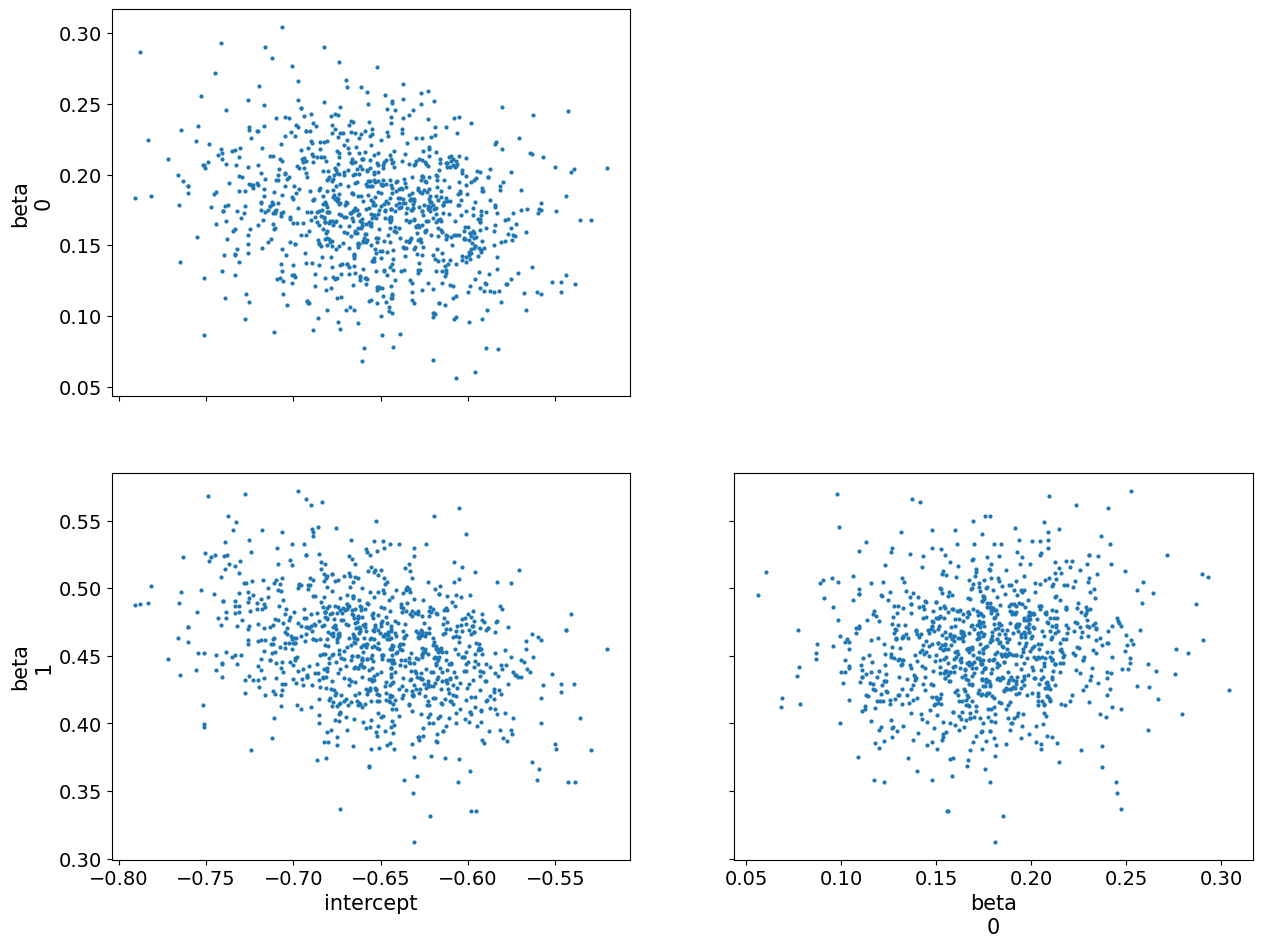

In [287]:
az.plot_pair(idata)

In [20]:
# TODO: As before, In your stan file, use the generated quantities block to sample 
# from the posterior predictive distribution and plot the posterior predictive distribution here.
# Display it in the same plot as the true $y$ data, and comment on comparing the two.